# Handwritten Digit Recognition Using PyTorch — Intro To Convolutional Neural Networks (CNNs)

We will use the most popular task in computational vision, [MNIST database](http://yann.lecun.com/exdb/mnist/). It is a collection of 70,000 handwritten digits split into TRAIN and TEST set of 60,000 and 10,000 images respectively.

![](https://camo.githubusercontent.com/d440ac2eee1cb3ea33340a2c5f6f15a0878e9275/687474703a2f2f692e7974696d672e636f6d2f76692f3051493378675875422d512f687164656661756c742e6a7067)

Picture Courtesy: https://camo.githubusercontent.com/d440ac2eee1cb3ea33340a2c5f6f15a0878e9275/687474703a2f2f692e7974696d672e636f6d2f76692f3051493378675875422d512f687164656661756c742e6a7067

## Import required Python libraries

In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm, trange

In [0]:
## Set seed of randomization and working device
manual_seed = 77
torch.manual_seed(manual_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    torch.cuda.manual_seed(manual_seed)

cuda


We will define a constant to decide whether to use the GPU (with CUDA specifically) or the CPU. 

If you don't have a GPU, set this is CPU. Later when we create tensors, this variable will be used to decide whether we keep them on CPU or move them to GPU.

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


`PyTorch` provides an easy implementation to download the cleaned and already prepared `MNIST data`.

Before downloading the data, we should define what are the transformations we want to perform on the image data.

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((1,), (1,)),
                              ])

1. **`transforms.Compose`** - Composes several transforms together.
2. **`transforms.ToTensor( )`** — Convert a `PIL Image` or `numpy.ndarray` to `tensor`, that are understandable for the computational method.
2. **`transforms.Normalize( )`** — Normalize a tensor image with mean and standard deviation. Our MNIST dataser is black-white pictures that only have one channel.

Now, we download the data sets, shuffle them and transform each of them to tensor. 
We load datasets to `DataLoader` to generate batches. We set the batch size as 64. Then, we save the transformed dataset in directory `./image_data/`.

In [0]:
batch_size = 64
trainset = datasets.MNIST('./image_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('./image_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

Extracting ./image_data/MNIST/raw/train-images-idx3-ubyte.gz to ./image_data/MNIST/raw


Extracting ./image_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./image_data/MNIST/raw


Extracting ./image_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./image_data/MNIST/raw




Extracting ./image_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./image_data/MNIST/raw
Processing...
Done!


## Exploring The Dataset
We will do some exploratory data analysis on our images and tensors.

Let's use the first batch as an example. 

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


The shape of images is `torch.Size([64,1,28,28])`, which suggests that there are 64 images in each batch and each image has one channel where includes dimension of `28 x 28 pixels`. The labels have a shape as `torch.Size([64])`, which suggests that there are 64 labels of images .

Let’s display first image from the training set.

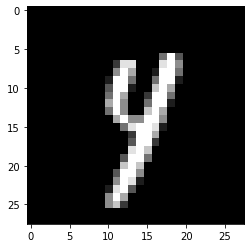

In [0]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray'); #use gray scale

Let’s display some more images.

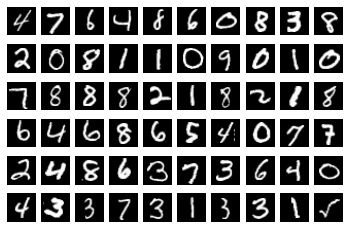

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray')

## Convolutional Neural Network (CNN)

![](https://www.frontiersin.org/files/Articles/273835/fpsyg-08-01745-HTML/image_m/fpsyg-08-01745-g001.jpg)

Picture Courtesy: https://www.frontiersin.org/articles/10.3389/fpsyg.2017.01745/full

1:- **Convolution:**
The first thing to understand in a Convolutional Neural Network is the actual convolution part. Convolution is essentially a moving kernel (or filter) across the image being studied.

![Moving 2×2 filter ](https://i1.wp.com/adventuresinmachinelearning.com/wp-content/uploads/2017/04/Moving-filter.jpg?w=733&ssl=1)

Picture Courtesy: https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

Input is a `5 x 5` tensor. The two outputs have been shown in the diagram above, where each output node is a map from a 2 x 2 input square with a stride of 1. The weight of the mapping of each input square is matrix $K$. Here, we assume that all the weights of $K$ equal to $0.5$.

$$out_1 = 0.5 in_1 + 0.5 in_2 + 0.5 in_6 + 0.5 in_7 $$

$$= 0.5 \times 2.0 + 0.5 \times 3.0 + 0.5 \times 2.0 + 0.5 \times 1.5 $$

$$= 4.25 $$


$$out_2 = 0.5 in_2 + 0.5 in_3 + 0.5 in_7 + 0.5 in_8 $$

$$= 0.5 \times 3.0 + 0.5 \times 0.0 + 0.5 \times 1.5 + 0.5 \times 0.5 $$

$$= 2.5 $$


Matrix $K$ is our kernel. We can apply multiple kernels to convolve this input tensor. The weights of individual kernel are held constant as they are applied over the input nodes, they can be trained to select certain features from the input data with backpropagation.

![](https://i2.wp.com/adventuresinmachinelearning.com/wp-content/uploads/2017/04/Moving-filter-with-multiple-filters.jpg?resize=768%2C311&ssl=1)

Picture Courtesy: https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

2:- **ReLU:** The next step in the CNN structure is to pass the output of the convolution operation through **a non-linear activation function**. **ReLU stands for Rectified Linear Unit,** and it just converts all negative pixel values to 0 while it retains the positive pixel values. The function itself is $output = Max(0, input)$. This provides the standard non-linear behavior that neural networks are known for.

![](https://miro.medium.com/max/357/1*oePAhrm74RNnNEolprmTaQ.png)
Picture Courtesy: https://miro.medium.com/max/357/1*oePAhrm74RNnNEolprmTaQ.png

3:- **Pooling:** The third element in CNN is **Max Pooling**. We pass over sections of our image and pool them into the highest value in the section. Depending on the size of the pool, this can greatly reduce the size of the feature set that we pass into the neural network. Here, we apply a `2 X 2` Max Pooling with a stride of 2. To handle the boundaries, we will pad the matrix. 

![max pooling](https://i0.wp.com/adventuresinmachinelearning.com/wp-content/uploads/2017/04/Max-pooling.jpg?resize=768%2C346&ssl=1)

There are other variants such as **mean pooling** (which takes the statistical mean of the contents) and **minimal pooling**.

4:- **Fully Connected Layers:** After the above preprocessing steps are applied, the output is passed into the traditional neural network architecture. Finally, the **Sigmoid fully connected layer** will give the prediction probilities across all labels.

![](fully_ll.png)

5:- **Dropout:** To regularize the model, we can use dropout in convolution layers, pooling layers, or fully connected layers.

## Build The Neural Network

We'll use two `2-D convolutional units`. In each units, we pass the data through **a convolutional layer -> ReLU -> max pooling layer** sequentially. Then, it follows by a Sigmoid (fully-connected) layer and a fully-connected layer.

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Let's build this model step by step. 

First, our input is image tensor. We use the first batch as an example. 

In [0]:
images, labels = dataiter.next()

print("images input:", images.shape)
print("labels:", labels.shape)

images input: torch.Size([64, 1, 28, 28])
labels: torch.Size([64])


Our input is a tensor which include 1 channel and 2 dimensions. So we will use [`nn.Conv2d()`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) to convolve the input data. 

To initialize `nn.Conv2d()`, you need to specify some hyper-parameters. 

The `in_channels` is the number of channel of input tensor. The `out_channels` is the number of channel of output tensor. You can consider `out_channels` as the number of kernels (or filters) in each convolutional layer. In this case, our `in_channels` equal to 1, and we want our outputs in 32 channels.   

The `kernel_size` argument is the size of the convolutional kernel – in this case we want `5 x 5` sized convolutional kernels – so the argument is `5`.  If you wanted kernels with different sized shapes in the height and width directions, you’d supply a tuple `(height-size, width-size)`. 

The `stride` controls the stride for the cross-correlation. We use stride of 1 here.

Finally, we want to specify the `padding` argument. The padding will help us handle the boundaries. The output size of any dimension from either a `convolutional kernel` or `pooling operation` can be calculated by the following equation:

$$W_{out}=\frac{(W_{in}-K+2P)}{S}+1$$

where $W_{in}$ is the width (or height) of the input, $K$ is the kernel size, $P$ is the padding and $S$ is the stride. The same formula applies to the height calculation, but seeing as our image and kernels are symmetrical the same formula applies to both. If we wish to **keep our input and output dimensions the same**, with a kernel size of `5` and a stride of `1`, it turns out from the above formula that we need a padding of `2`. Therefore, the argument for `padding` in Conv2d is `2`.

In [0]:
convolute_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
convolute_output = convolute_1(images)

In [0]:
print("convolute_output:", convolute_output.shape)

convolute_output: torch.Size([64, 32, 28, 28])


Then, we pass the output through a non-linearity function of `nn.ReLU()`. As you know, the `nn.ReLU()` function will not change the dimension of inputs.

In [0]:
relu = nn.ReLU()
relu_output = relu(convolute_output)
print("relu_output:", relu_output.shape)

relu_output: torch.Size([64, 32, 28, 28])


We feed the output of `ReLU layer` into a 2D max pooling layer. We want that the output dimensions will be half of the input dimensions in order to reduce the dimensions. 

To initialize [`nn.MaxPool2d`](https://pytorch.org/docs/stable/nn.html#maxpool2d), you need to specify some hyper-parameters. 

The `kernel_size` argument is the size of the convolutional kernel – in this case we want `2 x 2` sized max pooling kernel – so the argument is `2`. 

The `stride` is the stride of the kernel. We will use as same as the size of kernel. The output dimensions will be half of the input dimensions. 

In this case, we don't need pads. 

In [0]:
maxpool_1 = nn.MaxPool2d(kernel_size=2, stride=2,padding=0)
maxpool_output = maxpool_1(relu_output)
print("maxpool_output:",maxpool_output.shape)

maxpool_output: torch.Size([64, 32, 14, 14])


Now, let's move to second 2-D convolutional unit.
The input is the output of previous convolutional unit, i.e., maxpool_output. 

Similar with first convolutional unit, we will use `5 x 5` sized convolutional kernels – so the argument is `5`, and `stride` of 1 here. 

Then, our outputs should be in 64 channels.

We **keep our input and output dimensions the same**, with a kernel size of `5` and a stride of `1`.

$$P=\frac{(W_{out}-1) \times S - W_{in}+K}{2}$$

$$P=2$$

In [0]:
convolute_2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
convolute_output = convolute_2(maxpool_output)
print("convolute_output:",convolute_output.shape)

convolute_output: torch.Size([64, 64, 14, 14])


Same, we pass the output through a non-linearity function of `nn.ReLU()`.

In [0]:
relu = nn.ReLU()
relu_output = relu(convolute_output)
print("relu_output:", relu_output.shape)

relu_output: torch.Size([64, 64, 14, 14])


Using the same logic, we feed the output of ReLU layer into a 2D max pooling layer. The output dimensions should be half of the input dimensions in order to reduce the size. 

The `kernel_size` is want `2 x 2` sized max pooling kernel – so the argument is `2`. 

The stride is the same as the size of kernel. The output dimensions will be half of the input dimensions. Hence, we don't need pads. 

In [0]:
maxpool_2 = nn.MaxPool2d(kernel_size=2, stride=2)
maxpool_output = maxpool_2(relu_output)
print("maxpool_output:", maxpool_output.shape)

maxpool_output: torch.Size([64, 64, 7, 7])


Now, each images are represented in a tensor of `[64, 7, 7]` where 64 is the number of channels, and the information of each channel is represented in a `[7,7]` matrix. 

We need to flatten the `4D tensor` of output of convolutional layers to a `2D tensor` in order to match the input size of [fully connected layers](https://pytorch.org/docs/stable/nn.html#linear-layers) (i.e, `[batch size, feature_size]`. The `feature_size` will be `64 x 7 x 7 ` (i.e., 3136). 

In [0]:
flat_out = maxpool_output.view(maxpool_output.size(0), -1)
print("flat_out:", flat_out.shape)

flat_out: torch.Size([64, 3136])


Before the fully connected layers, we specify a [`drop-out layer`](https://pytorch.org/docs/stable/nn.html#dropout-layers) of 0.5 drop-out rate to avoid over-fitting in the model. 

In [0]:
drop_out = nn.Dropout(p=0.5)

In [0]:
drop_output = drop_out(flat_out)
print("drop_output:", drop_output.shape)

drop_output: torch.Size([64, 3136])


Finally,  it follows by a Sigmoid (fully-connected) layer and a fully-connected layer. 

In the first Sigmoid layer, the feature size of each input sample is 3136, and the feature size of each output sample is 1000.  

To create a Sigmoid fully connected layer in PyTorch, we use the `nn.Linear` method and `F.sigmoid()` function. 

In [0]:
fc1 = nn.Linear(7 * 7 * 64, 1000)
fc1_output = F.sigmoid(fc1(drop_output))
print("fc1_output:", fc1_output.shape)

fc1_output: torch.Size([64, 1000])


In the second layer, the feature size of each input sample is 1000, and the output will give the prediction probilities across all labels (i.e., digital 0-9).

In [0]:
fc2 = nn.Linear(1000, 10)
fc2_output = fc2(fc1_output)
print("fc2_output:", fc2_output.shape)

fc2_output: torch.Size([64, 10])


The `fc2_output` is the prediction of the CNN model. 
We can give this prediction and the true labels to a loss function to calculate the loss and backpropagate with the loss. 

In [0]:
# We use nn.CrossEntropyLoss() as our loss function. 
criterion = nn.CrossEntropyLoss()
criterion(fc2_output, labels)

tensor(2.3015, grad_fn=<NllLossBackward>)

### Creating CNN class

Let's put everything to a `class` object. 

We will create some [sequential layer objects](https://pytorch.org/docs/stable/nn.html#linear-layers) within the class `_init_` function. `sequential layer objects` is a sequential container. Modules will be added to it in the order they are passed in the constructor. 

First, we create conv_layer1 (`self.conv_layer1`) by creating a `nn.Sequential` object. This method is a handy way of creating a **convolution -> ReLU -> pooling** sequence. We put these module to the `nn.Sequential` object, sequentially.

Using the same logic, we create conv_layer2 (`self.conv_layer2`) where also includes **convolution -> ReLU -> pooling** sequence.

Then, we add a dropout layer and two fully connected layers. 

In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = F.sigmoid(self.fc1(out))
        out = self.fc2(out)
        return out

### Training the model

We create an instance of our ConvNet class, and define our loss function and optimizer:

In [0]:
model = ConvNet().to(device)
learning_rate = 0.001
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

We use a simplified version of the weight initialization scheme. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.1)$.

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.1)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

ConvNet(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

**Calculate the number of parameters.**

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,199,106 trainable parameters


`train()` and `evaluate()` functions

In [0]:
def train(model, iterator, optimizer, criterion):
    
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        images = batch[0].to(device)
        labels = batch[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)

        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.cpu().item()

    return epoch_loss / len(iterator)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    all_pred=[]
    all_label = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            images = batch[0].to(device)
            labels = batch[1].to(device)

            optimizer.zero_grad()

            outputs = model(images)

            loss = criterion(outputs, labels)

            epoch_loss += loss.cpu().item()

            # identify the predicted class for each example in the batch
            probabilities, predicted = torch.max(outputs.cpu().data, 1)
            # put all the true labels and predictions to two lists
            all_pred.extend(predicted)
            all_label.extend(labels.cpu())
    
    accuracy = accuracy_score(all_label, all_pred)
    f1score = f1_score(all_label, all_pred, average='macro') 
    return epoch_loss / len(iterator), accuracy, f1score

In [0]:
# Train the model
MAX_EPOCH = 5
total_step = len(trainloader)
loss_list = []
acc_list = []

for epoch in trange(MAX_EPOCH, desc="Epoch"):
    train_loss = train(model, trainloader, optimizer, criterion)  
    val_loss, val_acc, val_f1 = evaluate(model, valloader, criterion)

    # Create checkpoint at end of each epoch
    state_dict_model = model.state_dict() 
    state = {
        'epoch': epoch,
        'state_dict': state_dict_model,
        'optimizer': optimizer.state_dict()
        }

    torch.save(state, "./ckpt/MNIST_CNN_"+str(epoch+1)+".pt")

    print('\n Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation F1: {:.4f}'.format(epoch+1, MAX_EPOCH, train_loss, val_loss, val_acc, val_f1))
    

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch:  20%|██        | 1/5 [00:15<01:00, 15.13s/it]


 Epoch [1/5], Train Loss: 0.2123, Validation Loss: 0.0511, Validation Accuracy: 0.9834, Validation F1: 0.9833


Epoch:  40%|████      | 2/5 [00:30<00:45, 15.18s/it]


 Epoch [2/5], Train Loss: 0.0740, Validation Loss: 0.0344, Validation Accuracy: 0.9887, Validation F1: 0.9886


Epoch:  60%|██████    | 3/5 [00:45<00:30, 15.17s/it]


 Epoch [3/5], Train Loss: 0.0538, Validation Loss: 0.0304, Validation Accuracy: 0.9909, Validation F1: 0.9908


Epoch:  80%|████████  | 4/5 [01:00<00:15, 15.14s/it]


 Epoch [4/5], Train Loss: 0.0472, Validation Loss: 0.0271, Validation Accuracy: 0.9908, Validation F1: 0.9907


Epoch: 100%|██████████| 5/5 [01:15<00:00, 15.14s/it]


 Epoch [5/5], Train Loss: 0.0376, Validation Loss: 0.0286, Validation Accuracy: 0.9920, Validation F1: 0.9920


### Visualization
We also introduce a online tool to visualize the CNN model. 

* Visualizing the “activations” of the layers: https://cs.ryerson.ca/~aharley/vis/conv/

![](http://www.programmersought.com/images/544/46bde7423a265a6ba287620bc5c47f68.png)
Picture Courtesy: http://www.programmersought.com/article/23607351/

**Reference:**
* https://pytorch.org/docs/stable/index.html
* https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/
* https://nextjournal.com/gkoehler/pytorch-mnist
* https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
* https://algorithmia.com/blog/convolutional-neural-nets-in-pytorch
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* http://cs231n.stanford.edu/